In [1]:
import numpy as np
import torch
from numpy import newaxis
import pandas as pd
from keras.layers import Dense, Activation, Dropout, LSTM, GRU
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential

plt.style.use("fivethirtyeight")

/tmp/ipykernel_870/1338838021.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
TIME_WINDOW = 100

In [3]:
sc = MinMaxScaler(feature_range=(0,1))
def load_data(df, column, seq_len, normalise_window):

    # each row is a timestep in our data
    # we are selecting only one column, therefore this is a univariate time series problem
    data = df.loc[:, column]

    sequence_length = seq_len + 1
    result = []
    
    # Sequence length is the range we want to predict, which must be shorter than the available data
    # To get the train dataset, we are windowing through our dataset and collect windows of size sequence_length
    # e.g. if sequence_length = 10 and data_length = 100: range(100 - 10) <=> range(90) <=> [0,1,2,3,4, ..., 89]
    # -> we have data_length - sequence_length positions to start the window
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    # each window is normalised such that values are between 0 and 1
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    # use the first 90% for training and the last 10 percent for testing
    # usually it makes sense to test on the most recent windows because prediction will be on consecutive windows
    # -> If there is data drift, we might see it in the test results already
    offset = round(0.9 * result.shape[0])
    train = result[:int(offset), :]
    # this operation is in place
    np.random.shuffle(train)
    
    # (because we are in a time series, the last element of the train data is the label for the preceding sequence)
    # Here, all but the last columns of the train data is assumed to be the features, the last column is assumed to be the label
    # This means, that we must have assigned the label already before calling this function
    x_train = train[:, :-1]
    y_train = train[:, -1]

    x_test = result[int(offset):, :-1]
    y_test = result[int(offset):, -1]

    # reshape to (0.9 * sequence_length , 1, 1)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        # each value in window is divided by the first value in the window minus 1. Why?
        # -> formula: x - x_min / x_max - x_min , x_min = 0, -1 to move scale to -1 = min and 0 = max
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)

    return normalised_data

def predict_sequence_full(model, data, window_size):
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        # We append the prediction of the current frame to predicted
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        # move current frame one frame further
        curr_frame = curr_frame[1:]
        # We insert the latest prediction on top of the curr_frame array. But why?
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor="white")
    ax = fig.add_subplot(111)
    ax.plot(true_data, label="True Data")
    plt.plot(predicted_data, label="Prediction")
    plt.legend()
    plt.show()


def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor="white")
    ax = fig.add_subplot(111)
    ax.plot(true_data, label="True Data")
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label="Prediction")
        plt.legend()
    plt.show()

<Axes: >

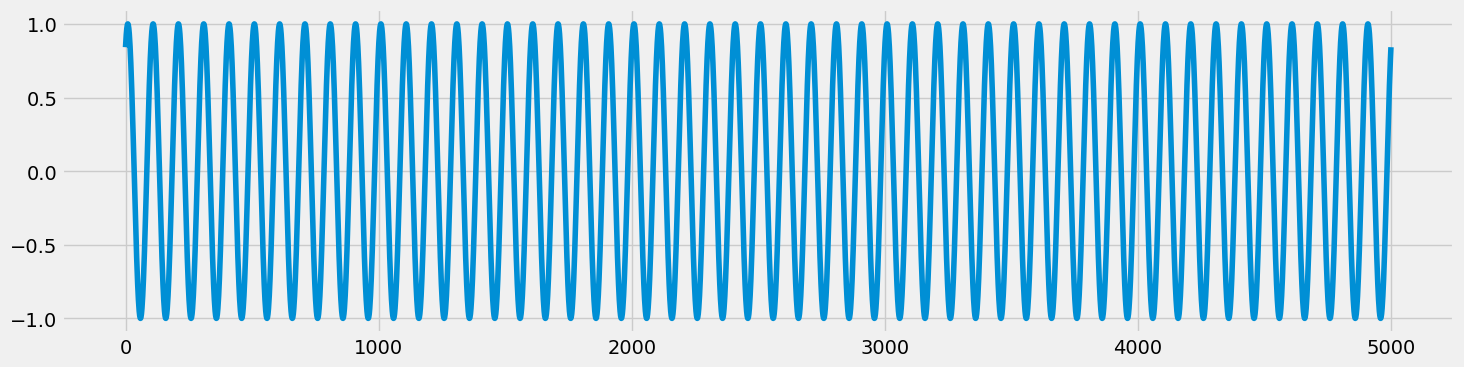

In [4]:

# Load the data
dataset = pd.read_csv('../data/sinwave/Sin Wave Data Generator.csv')
dataset["Wave"][:].plot(figsize=(16,4),legend=False)

In [5]:
# Prepare the dataset, note that all data for the sinus wave is already normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable, in this case a stock price

feature_train, label_train, feature_test, label_test = load_data(dataset, 'Wave', TIME_WINDOW, False)

print ('Datasets generated')

Datasets generated


In [6]:
# The LSTM model I would like to test
# Note: replace LSTM with GRU or RNN if you want to try those
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam")

print("model compiled")
print(model.summary())

model compiled


/opt/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)           │     10,400 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout (Dropout)               │ (None, 100, 50)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)               │     60,400 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_1 (Dropout)             │ (None, 100)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 1)                 │        101 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 70,901 (276.96 KB)

 Trainable params: 70,901 (276.96 KB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=10, validation_data = (feature_test, label_test))

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 419ms/step - loss: 0.3113 - val_loss: 0.0927
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step - loss: 0.0661 - val_loss: 0.0037
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - loss: 0.0124 - val_loss: 0.0020
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 418ms/step - loss: 0.0072 - val_loss: 0.0037
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 404ms/step - loss: 0.0068 - val_loss: 5.3852e-04
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 435ms/step - loss: 0.0054 - val_loss: 3.3402e-04
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 432ms/step - loss: 0.0045 - val_loss: 4.5880e-04
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 540ms/step - loss: 0.0044 - val_loss: 1.3272e-04
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step - loss: 0.0041 - val_loss: 1.0833e-04
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step - loss: 0.0039 - val_loss: 1.3850e-04


In [8]:
#Let's use the model and predict the wave
predictions= predict_sequence_full(model, feature_test, TIME_WINDOW)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━

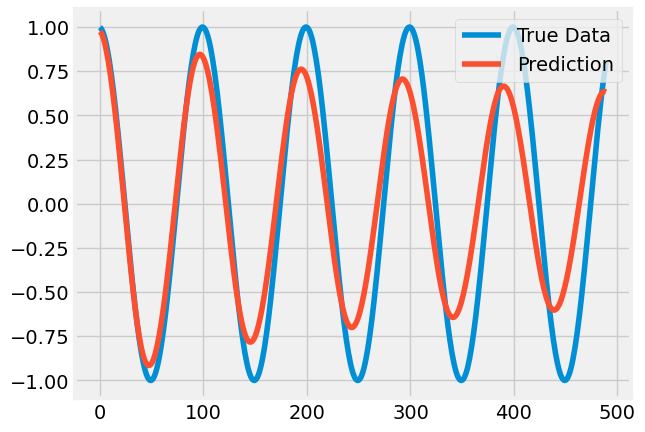

In [9]:
plot_results(predictions,label_test)